# The Sound Fourier Transform

Explore  how  Fourier  transform  can  help  us understand human sounds.  Two years ago, the Laurel/Yanny audio clip ignited the internet.  Some people  hear  the  clip  play  as  “Laurel”  and  some  hear  it  as  “Yanny”. Several  news  outlets  posted explanations of the different perceptions, and made tools that let you perceive both interpretations.  

In [2]:
import numpy as np
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
# %matplotlib inline
import os

## Load the `.wav` file

I’ll load the Laurel/Yanny audio clip, and process it in several ways that accentuate the “Laurel” or “Yanny” perceptions.It is easy to load an audio file, such as the LaurelYanny.wav file. I also  need  to  keep  track  of  the  “sample  rate”  of  the  file,  which corresponds to the number of datapoints per second

In [4]:
with open("laurel_yanny.wav", 'rb') as file:
    sampleRate, data = wavfile.read(file)

Play the sound by  writing the read file into a .wav file.

In [5]:
def writeWavFile(data, filename, sampleRate):
    data1 = (data* 1/np.max(abs(data)) * 32767).astype(np.int16)
    with open(filename + '.wav', 'wb') as f:
        wavfile.write(f, sampleRate, data1)

I only hear "Laurel" -- EXCLUSIVELY! You?

## Plot the raw signal

Plot the waveform that this 43,008 point signal array represents.

record time is 0.9752380952380952 s


Text(0, 0.5, 'Speaker Cone Displacement')

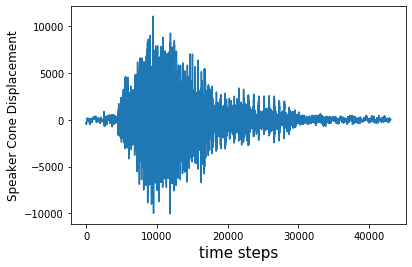

In [12]:
plt.figure()
plt.plot(data)
recordTime = data.shape[0]/sampleRate # seconds
print("record time is", recordTime, "s")
plt.xlabel('time steps', fontsize = 15)
plt.ylabel('Speaker Cone Displacement',fontsize = 12)

## Take the Discrete Fourier Transform

Take the discrete Fourier transform of the signal, and plot the real number corresponding to the magnitude of each coefficient of the Fourier transform. The great thing about taking the `Python` DFT is that it is implemented using a cool algorithm ([FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform)) that runs in near linear time (technically $O(Nlog(N))$) in the length of the vector (think a single pass efficiency! that's very good for bulky data). 

Text(0, 0.5, 'Magnitude of fourier coefficients')

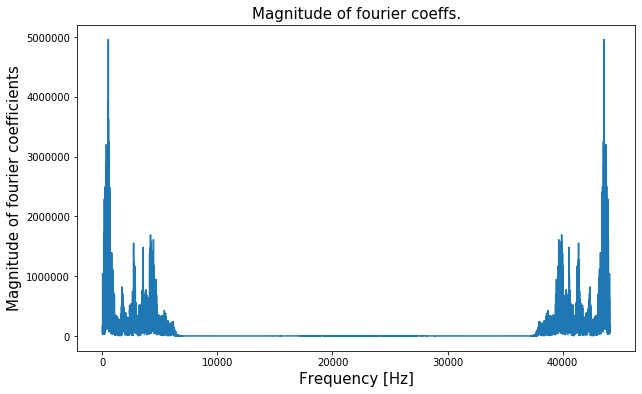

In [14]:
sp = np.fft.fft(data)
freq = np.fft.fftfreq(n=data.shape[0], d=timestep)
plt.figure(figsize = (10,6))
plt.plot(np.arange(len(sp))/recordTime, abs(sp))
plt.xlabel('Frequency [Hz]', fontsize = 15)
plt.title("Magnitude of fourier coeffs.", fontsize = 15)
plt.ylabel('Magnitude of fourier coefficients', fontsize = 15)


## Observations
1. Notice the symmetry of the plot of the magnitude of the Fourier coefficients – that is due to thenature of the rows of the Fourier transformation matrix.
2. The signal’s Fourier transform has a fairly sparse representation – this plot above is expected because from the plot of previous section, it can be seen that the audio signal is in fact very dense in the temporal space but has some periodicity in it. **A typical rule of thumb for signals that are dense in the physical space is that they are sparse in the Fourier space. And vice-versa. Typically -- Not always**
3. There is a primary frequency component with the largest Fourier coefficient at frequency<1000Hz.
4. There are 4 other key frequency regimes where the Fourier coefficient magnitude peaks. All these peaks are comparable yet smaller than the component with highest corresponding coefficient.

## Plot the spectrogram to analyze the energy of signal

The “spectrogram” of the signal illustrates how the amount of high/low frequencies change over the course of the audio clip. Specifically, I'll chop the signal up into 500-sample  long  blocks,  and  compute  the  Fourier  transform  for  each  chunk.

The x axis corresponds tothe index of the chunk, and the y values corresponds to frequencies, and the value at location x, y corresponds to the magnitude of the y$^{th}$ Fourier coefficient for the x$^{th}$ chunk.  Since frequencies beyond the 80$^{th}$ Fourier coefficient are too high for humans to hear, the y-axis should just go from 1 to 80. 

Text(0.5, 1.0, 'Heatmap of Abs(Fourier Coeffs.)')

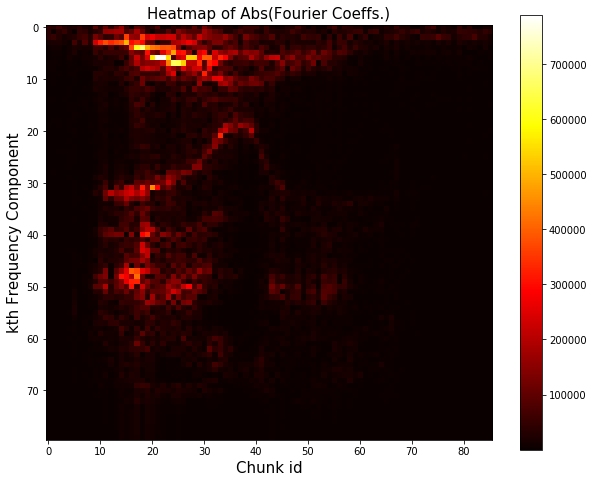

In [19]:
numChunks = np.floor(data.shape[0]/500).astype(np.int)
A = np.zeros((80, numChunks))
for chunk in range(numChunks):
    start = chunk*500
    end = start+500
    absCoeffs = abs(np.fft.fft(data[start:end]))[0:80].reshape(80,)
    A[:, chunk] = absCoeffs

plt.figure(figsize = (10,8))
plt.imshow(A, cmap = 'hot')
plt.colorbar()
plt.xlabel('Chunk id', fontsize = 15)
plt.ylabel('kth Frequency Component', fontsize = 15)
plt.title('Heatmap of Abs(Fourier Coeffs.)', fontsize = 15)


There is for sure some curious structure. Let's take the log to enhance the contrast

Text(0.5, 1.0, 'Heatmap of Abs(Fourier Coeffs., log for contrast)')

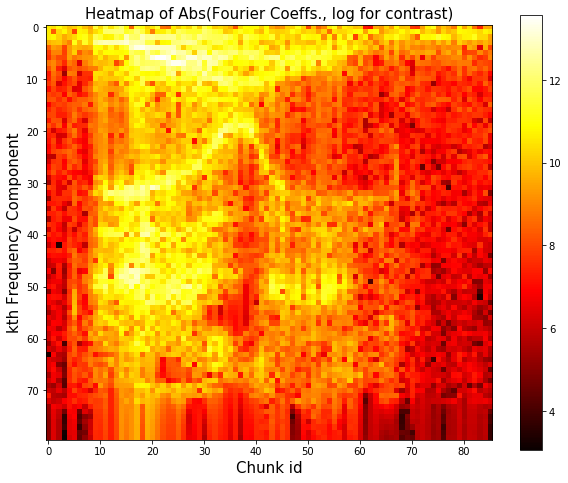

In [23]:
plt.figure(figsize = (10,8))
plt.imshow(np.log(A), cmap = 'hot')
plt.colorbar()
plt.xlabel('Chunk id', fontsize = 15)
plt.ylabel('kth Frequency Component', fontsize = 15)
plt.title('Heatmap of Abs(Fourier Coeffs., log for contrast)', fontsize = 15)


**Non monotonic energy transfer trend:** Energy is getting transferred from lower to higher frequency with time for "lower" frequency range (freq $<$ 17th component freq) and the transfer reverses direction after some time (after chunk 40 in particular). Reverse energy transfer observed for frequencies in the 17th-40th band.

## Tweaking the signal to achieve pure "Laurel"/"Yanny" sound

Now change the signal to sound more like “Laurel” or, more like “Yanny”.  To start,  take the original audio, and try 
1.  zeroing out all “high” frequencies—frequencies abovea certain threshold , and 
2.  zeroing out all frequencies below .  

This can be accomplished by multiplying  the  Fourier  transform  of  the  signal  by  the  thresholding  function, then  taking  the inverse Fourier transform.  This is what the function below avhieves

In [30]:
def thresholding(limit, threshold):
    """
    Thresholding function to curb frequencies beyong a threshold
    args:
        limit: Thresholding Type : "Upper" or "Lower"  
                            -- "Upper" corresponds to zeroing out on the higher frequencies
                            -- "Lower" corresponds to zeroing out on the lower frequencies
        threshold: thresholding frequency
    """
    if limit=='Upper':
        c1=1
        c2=0
    elif limit=='Lower':
        c1=0
        c2=1

    thresholdedFFT = np.hstack((c1*sp[0:threshold],c2*sp[threshold:-threshold], c1*sp[-threshold:])).ravel()
    plt.figure()
    plt.plot(np.arange(len(sp))/recordTime, abs(thresholdedFFT))
    plt.xlabel('Frequency [Hz]', fontsize = 15)
    plt.title(limit + " Thresholded signal FFT", fontsize = 15)
    plt.ylabel('Magnitude of fourier coefficients', fontsize = 12)
    test_o = np.fft.ifft(thresholdedFFT)

    # audio signal written to current directory for listening
    plt.figure()
    plt.plot(test_o)
    plt.xlabel('time steps', fontsize = 15)
    plt.ylabel('Modified Signal ',fontsize = 13)
    fname = 'testing'+limit
    writeWavFile(test_o, fname, sampleRate)

Playing around with the threshold value tells me the threshold of around 1850 Hz such that the “low” frequency version sounds like “Laurel” and the “high” frequency version sounds like “Yanny/Yarry”

1845.703125


C:\Users\saksh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


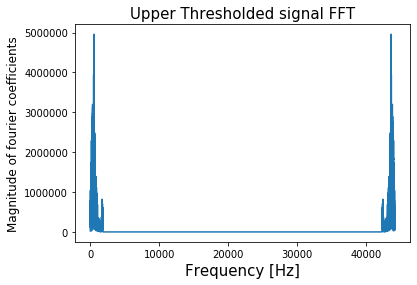

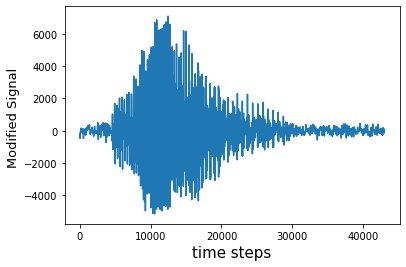

In [31]:
threshold =  1800
freqThreshold = 1800/recordTime
print(freqThreshold)
thresholding('Upper', threshold)

C:\Users\saksh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


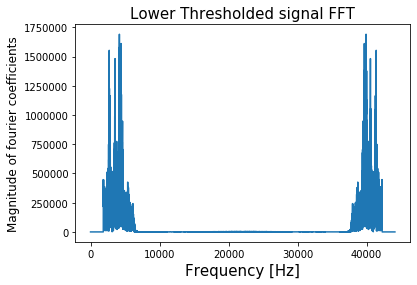

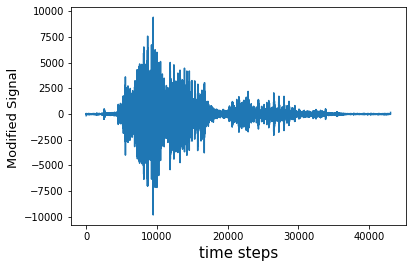

In [32]:
thresholding('Lower', threshold)

## Other ways of bringing out the Laurel or Yanny in the original audio

Keep manually changing the playback by changing the sampling rate and replaying this file

In [95]:
writeWavFile(data, 'playx_testing', np.floor(2*sampleRate).astype(np.int))

### Observations


- For very low playbacks of 0.25x-0.45x, I hear some very disturbing and insidious sounds haha!
- At playback of 0.5x -- I hear "LOL"
- But I am amazed at what happens at playback of 0.7-0.9 -- I hear "Yanny"/"Yarry" exclusively !!
- At orginal playback (1x) and for higher playbacks (>1x), I hear "Laurel" exclusively back again
- And some funny "Laurel" like sound at 2x


## Conclusion

Clearly, from our analysis, we now know that different humans are perceptive to different frequencies. This must be a  biological characteristic and needs further looking into! 